<a href="https://colab.research.google.com/github/Ana-AlonsoCanizares/AA_GRUPO3/blob/main/Lab04_Pr03_enfermeria.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Puestos de enfermería

Una empresa de colocación de trabajadores pretende hacer una aplicación para ser más eficiente en los enfermeros y enfermeras que asignan para cuidados en hogares. Para ello se dispone del archivo csv “enfermeria” con las características de las distintas personas que pueden optar a los puestos. Crear un modelo que agrupe los candidatos y establezca como se relacionan entre ellos jerárquicamente.

1) Utiliza varias configuraciones para el modelo que más se adapte y teniendo en cuenta los tipos
de distancias entre elementos. ¿Cuál es la k del modelo? (1 puntos)

2) Dibuja un dendograma con los clusters obtenidos. Explica alguna de las relaciones interesantes que puedas
encontrar. (1 punto)

#Importación de librerías

In [52]:
import mlxtend
from mlxtend.frequent_patterns import association_rules, apriori
from mlxtend import frequent_patterns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from prettytable import PrettyTable
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.preprocessing import OrdinalEncoder

%matplotlib inline 
from sklearn.cluster import KMeans
from sklearn import datasets

In [36]:
# Lectura de la base de datos
filename = 'enfermeria.csv'
data = pd.read_csv(filename, sep = ',')

data.head(20)

,parents_occupation,childs_nursery,family_form,number_children,housing_conditions,financial_standing,social_conditions,health_conditions,recommendation
0,usual,proper,complete,1,convenient,convenient,nonprob,recommended,recommend
1,usual,proper,complete,1,convenient,convenient,nonprob,priority,priority
2,usual,proper,complete,1,convenient,convenient,nonprob,not_recom,not_recom
3,usual,proper,complete,1,convenient,convenient,slightly_prob,recommended,recommend
4,usual,proper,complete,1,convenient,convenient,slightly_prob,priority,priority
5,usual,proper,complete,1,convenient,convenient,slightly_prob,not_recom,not_recom
6,usual,proper,complete,1,convenient,convenient,problematic,recommended,priority
7,usual,proper,complete,1,convenient,convenient,problematic,priority,priority
8,usual,proper,complete,1,convenient,convenient,problematic,not_recom,not_recom
9,usual,proper,complete,1,convenient,inconv,nonprob,recommended,very_recom


In [37]:
# Revisión de los tipos de datos
print(data.shape)

(12960, 9)


In [38]:
# No hay nan
print(data.info())

# Quitamos los duplicados que tampoco hay
data = data.drop_duplicates()

print(data.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12960 entries, 0 to 12959
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   parents_occupation  12960 non-null  object
 1   childs_nursery      12960 non-null  object
 2   family_form         12960 non-null  object
 3   number_children     12960 non-null  object
 4   housing_conditions  12960 non-null  object
 5   financial_standing  12960 non-null  object
 6   social_conditions   12960 non-null  object
 7   health_conditions   12960 non-null  object
 8   recommendation      12960 non-null  object
dtypes: object(9)
memory usage: 911.4+ KB
None
(12960, 9)


In [39]:
data.value_counts(data['parents_occupation'])

parents_occupation
great_pret     4320
pretentious    4320
usual          4320
dtype: int64

In [40]:
col_categoricas = ['parents_occupation',	'childs_nursery',	'family_form',	'number_children',	'housing_conditions',	'financial_standing',	'social_conditions',	'health_conditions',	'recommendation']

encoder = OrdinalEncoder()
encoder.fit(data[col_categoricas])

OrdinalEncoder()

In [41]:
data[col_categoricas] = encoder.transform(data[col_categoricas])

In [42]:
data

,parents_occupation,childs_nursery,family_form,number_children,housing_conditions,financial_standing,social_conditions,health_conditions,recommendation
0,2.0,3.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0
1,2.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,2.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.0,3.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0
4,2.0,3.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...
12955,0.0,4.0,2.0,3.0,1.0,1.0,2.0,1.0,3.0
12956,0.0,4.0,2.0,3.0,1.0,1.0,2.0,0.0,0.0
12957,0.0,4.0,2.0,3.0,1.0,1.0,1.0,2.0,3.0
12958,0.0,4.0,2.0,3.0,1.0,1.0,1.0,1.0,3.0


In [65]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

dist_matrix = pdist(data_scaled, metric='hamming')

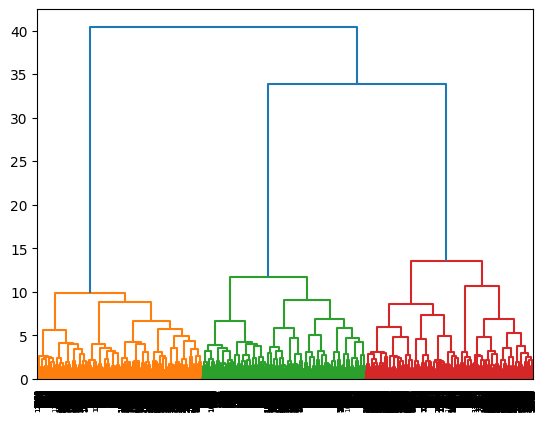

In [66]:
linkage_matrix = linkage(dist_matrix, method='ward')
dendrogram(linkage_matrix)
plt.show()

In [59]:
distortions = []
K = range(1,15)
for k in K:
    kmeanModel = KMeans(n_clusters=k, init = 'k-means++', random_state = 42)
    kmeanModel.fit(data)
    distortions.append(kmeanModel.inertia_)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

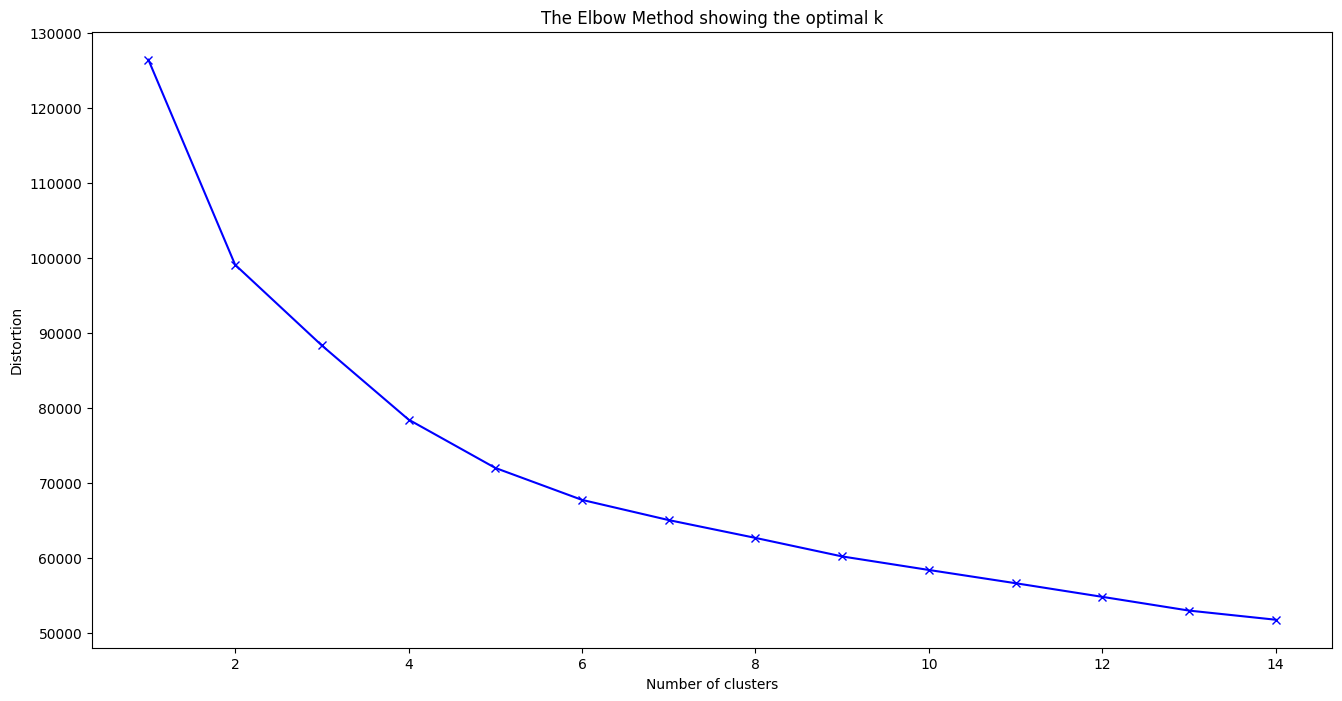

In [63]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [61]:
k = 3
model = AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='ward')
model.fit(data_scaled)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


AgglomerativeClustering(affinity='euclidean', n_clusters=3)

In [62]:
data['cluster'] = model.labels_

data.value_counts(data['cluster'])

cluster
1    4355
0    4344
2    4261
dtype: int64